# Global Health Paradoxes

## 1. Introduction

This analysis explores global health trends through metrics such as Healthy Life Expectancy (HALE), smoking prevalence, alcohol consumption per capita, and healthcare expenditures. The aim is to identify patterns and disparities in health outcomes across countries with different income levels.

Throughout this work, I test several hypotheses:
*	Higher smoking prevalence correlates with lower Healthy Life Expectancy.
*	Higher alcohol consumption per capita is associated with lower Healthy Life Expectancy.
*	Higher healthcare expenditures are linked to higher Healthy Life Expectancy.

The data used in this analysis is sourced from the World Health Organization’s (WHO) data hub. The WHO provides independent indicators in varying formats and time periods, requiring careful preparation. Data cleaning and preprocessing, which were carried out during the Data Wrangling stage, are outside the scope of this discussion.

## 2. Descriptive Overview: Getting to Know the Data

To ensure a solid foundation for analysis, the dataset underwent extensive preparation, including interpolating missing values for numeric fields, filtering data up to the year 2020, and addressing incomplete records.

The dataset includes the following information:
*	Country and region details.
*	Income categories based on World Bank Income Codes.
*	Healthy Life Expectancy (HALE): at birth and at age 60, measured in years.
*	Smoking prevalence: percentage of the population that smokes.
*	Alcohol consumption: measured in liters of pure alcohol per capita.
*	Current Health Expenditure (CHE): expressed as a percentage of GDP.

The dataset represents 193 countries worldwide and spans the years 2000 to 2020.


In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Loading the data
health_data = pd.read_csv(Path('__file__').parent / 'data' / 'health_data.csv', index_col=0)

In [ ]:
# Interpolating data for missing periods if data for this country is available for other periods
fields = health_data.select_dtypes('float64').columns
for field in fields:
    country_codes_not_na_values = health_data.loc[~health_data[field].isna(), 'CountryCode'].unique()
    filter_countries_with_data = health_data['CountryCode'].isin(country_codes_not_na_values)
    df1 = health_data[filter_countries_with_data].copy()

    df1 = df1.sort_values(['Country', 'Year'])
    df1[field] = df1[field].interpolate()

    health_data = pd.concat([df1, health_data[~filter_countries_with_data]])
    del(df1)

In [ ]:
# Filtering the data for the period before 2020, as data after that is highly fragmented
health_data = health_data[health_data['Year'] <= 2020]

# Replacing missing values for the World Bank Income Code with a space
health_data['WBIncomeCode'] = health_data['WBIncomeCode'].fillna('')

# Deleting records with predominantly missing values
health_data = health_data.drop(columns= 'Spending more 10% (%)', axis=1)
health_data = health_data.dropna(how = 'any', axis= 0)

In [26]:
# The data available
health_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3316 entries, 386 to 4051
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CountryCode                         3316 non-null   object 
 1   Country                             3316 non-null   object 
 2   Region                              3316 non-null   object 
 3   RegionCode                          3316 non-null   object 
 4   WBIncomeCode                        3316 non-null   object 
 5   Year                                3316 non-null   int64  
 6   Index                               3316 non-null   object 
 7   HALE at birth (years)               3316 non-null   float64
 8   HALE at age 60 (years)              3316 non-null   float64
 9   CHE as percentage of GDP (%)        3316 non-null   float64
 10  Share of smokers (%)                3316 non-null   float64
 11  Alcohol, total per capita (litres)  3316 non-n

## 3. Predictably: Wealthier Countries Have Longer Life Expectancies

The dataset provides two types of Healthy Life Expectancy (measured in years): at birth and at age 60. For the purpose of this analysis, I have chosen the latter, as Healthy Life Expectancy at birth is more influenced by non-health factors such as infant mortality, workplace accidents, road incidents and other.

The Healthy life expectancy (HALE) in years at age 60 represents the average number of years in full health a person (usually at age 60) can expect to live based on current rates of ill-health and mortality.

As shown in the graph below, it comes as no surprise that people in wealthier countries tend to live longer.

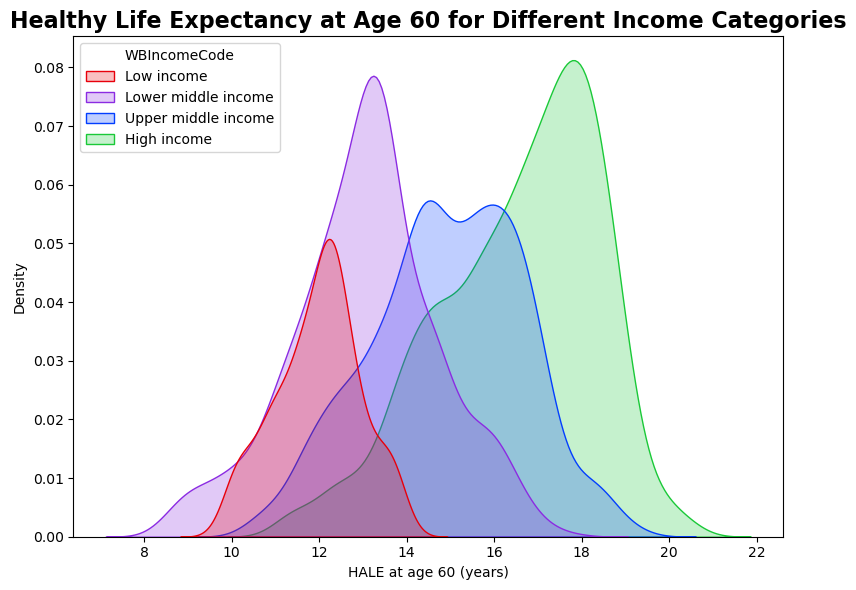

In [40]:
# The histogram of HALE at age 60
order = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

colors = sns.color_palette('bright', n_colors=16)  # Use any palette and specify the number of colors needed

# Create the dictionary
palette = {
    'Low income': colors[3],   # First color from the palette
    'Lower middle income': colors[4],  # Second color
    'Upper middle income': colors[0],  # Third color
    'High income': colors[2]   # Fourth color
    }

fig, ax = plt.subplots(figsize = (8, 6))
sns.kdeplot(data = health_data, 
            x = 'HALE at age 60 (years)', 
            hue = 'WBIncomeCode', hue_order = order,
            fill = True, palette = palette)

plt.title('Healthy Life Expectancy at Age 60 for Different Income Categories', fontsize = 16, fontweight = 'bold')
plt.tight_layout()
plt.show()

## 4. Signs of Progress: Healthy Life Expectancy Increased Across All Income Categories (2000–2020)

The data shows a significant increase in the median Healthy Life Expectancy across all income categories during this period. This indicates that, on average, people in most countries are living longer lives.

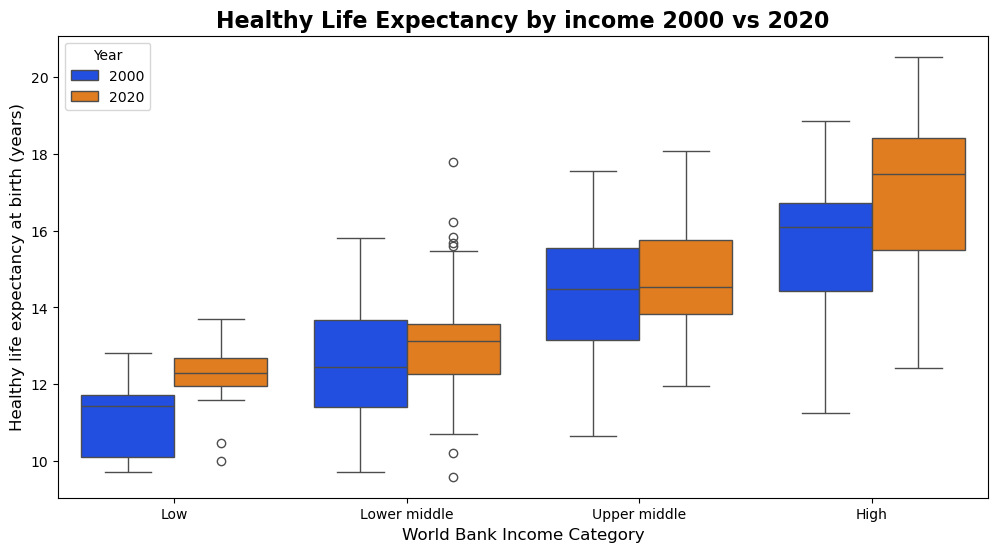

In [41]:
# HALE 2020 vs. 2000
fig, ax = plt.subplots(figsize = (12, 6))
ax = sns.boxplot(data = health_data[health_data['Year'].isin([2000, 2020])], x = 'WBIncomeCode', y = 'HALE at age 60 (years)', 
                 hue = 'Year', order = order, palette = 'bright')

ax.set_xticks(range(len(order))) 
ax.set_xticklabels(['Low', 'Lower middle', 'Upper middle', 'High'])

plt.xlabel('World Bank Income Category', fontsize = 12)
plt.ylabel('Healthy life expectancy at birth (years)', fontsize = 12)
plt.title('Healthy Life Expectancy by income 2000 vs 2020', fontsize = 16, fontweight = 'bold')
plt.show()

In [99]:
# Definition of plotting functions

def plot_one_scatter(data, x, y, y_min, y_max, hue, year, ax, alpha = 1):
    # Scatter plot with consistent colors
    ax_ = sns.scatterplot(data = data, x = x, y = y, hue = hue, 
                    ax = ax, palette= palette)
    
    # Add trend lines for each income code
    for income_code in sorted(data['WBIncomeCode'].unique()):
        ax_ = sns.regplot(data=data[data['WBIncomeCode'] == income_code], x = x, y = y, 
                    color=palette[income_code], scatter=False, #ci=False,
                    line_kws={'linewidth': 1.5, 'linestyle': ':', 'alpha': alpha}, 
                    ax = ax)
        
    ax_.set_title(f"Year: {year}")
    ax_.set_ylim(y_min, y_max)
    ax_.legend().remove()

    return ax_


def plot_scatters_income_categories(data, x, y, hue, legend_title, title, years = [2000, 2010, 2015, 2020]):
    y_min = min(data.loc[data['Year'].isin(years), y])
    y_max = max(data.loc[data['Year'].isin(years), y])
    
    rows = int(np.ceil(len(years) / 2))

    fig, axes = plt.subplots(nrows= rows, ncols=2, figsize=(12, 6 * rows), sharex = True, sharey = True)
    for i, year in enumerate(years):
        dt = data.loc[data['Year'] == year]
        if rows > 1:
            axes[i // 2][i % 2] = plot_one_scatter(data = dt, x = x, y = y, y_min = y_min, y_max = y_max,
                                                   hue = hue, year = year, ax = axes[i // 2][i % 2])
            handles, labels = axes[0][0].get_legend_handles_labels()
        else: 
            axes[i] = plot_one_scatter(data = dt, x = x, y = y, y_min = y_min, y_max = y_max,
                                       hue = hue, year = year, ax = axes[i])
            handles, labels = axes[0].get_legend_handles_labels()
         
    # Add one shared legend for the whole figure
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=4, title = legend_title)

    # Add the title for the figure
    fig.suptitle(title, fontsize = 16, fontweight = 'bold')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend at the top

    # Show the plot
    plt.show()

### … but COVID-19 Disrupted the Trends Across All Categories!!!

Several factors may explain this disruption:  
1.	Increased mortality directly caused by COVID-19.
2.	The impact on mental health due to fears, isolation, loss of loved ones, economic disruption, and other stress-inducing factors.

Further research is required to better understand the extent of these influences and identify additional contributing factors, but such an investigation falls outside the scope of this analysis.

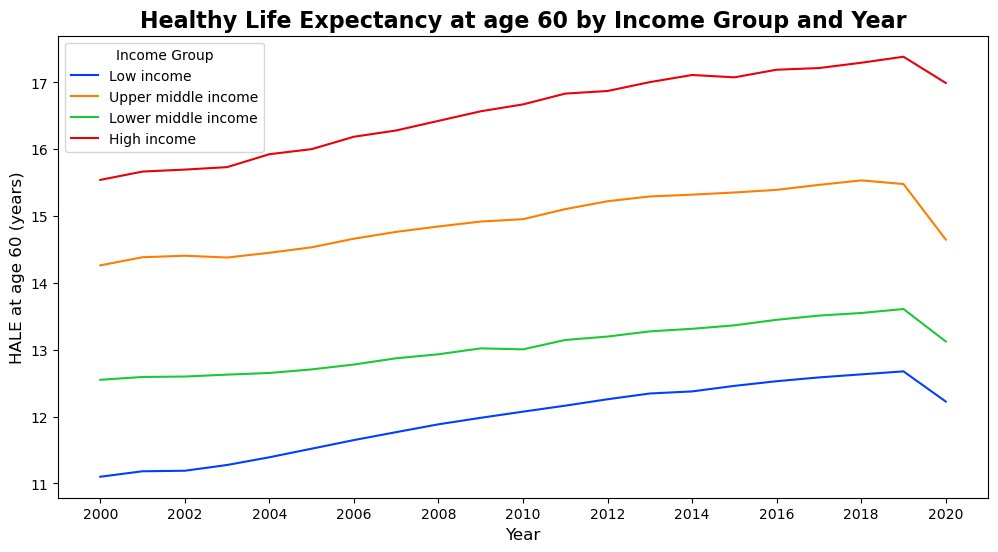

In [43]:
# The HALE trends over the years
order = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

fig, ax = plt.subplots(figsize = (12, 6))
ax = sns.lineplot(data = health_data, x = 'Year', y = 'HALE at age 60 (years)', 
                 hue = 'WBIncomeCode', palette = 'bright', errorbar= None)

xticks = list(filter(lambda x: (x + 1) % 2, health_data['Year'].sort_values().unique()))
ax.set_xticks(xticks)

plt.xlabel('Year', fontsize = 12)
plt.ylabel('HALE at age 60 (years)', fontsize = 12)
plt.title('Healthy Life Expectancy at age 60 by Income Group and Year', fontsize = 16, fontweight = 'bold')
plt.legend().set_title('Income Group')
plt.show()

## 5. Alcohol Paradox: Higher Alcohol Consumption Correlates with Higher Healthy Life Expectancy?!

The graphs below reveal a surprising trend: Healthy Life Expectancy appears to increase with higher alcohol consumption! This unexpected finding contradicts the widely accepted understanding of alcohol’s harmful effects on health.

__Warning:__ Don’t rush to raise a glass! The devil is in the details, and further analysis is essential.

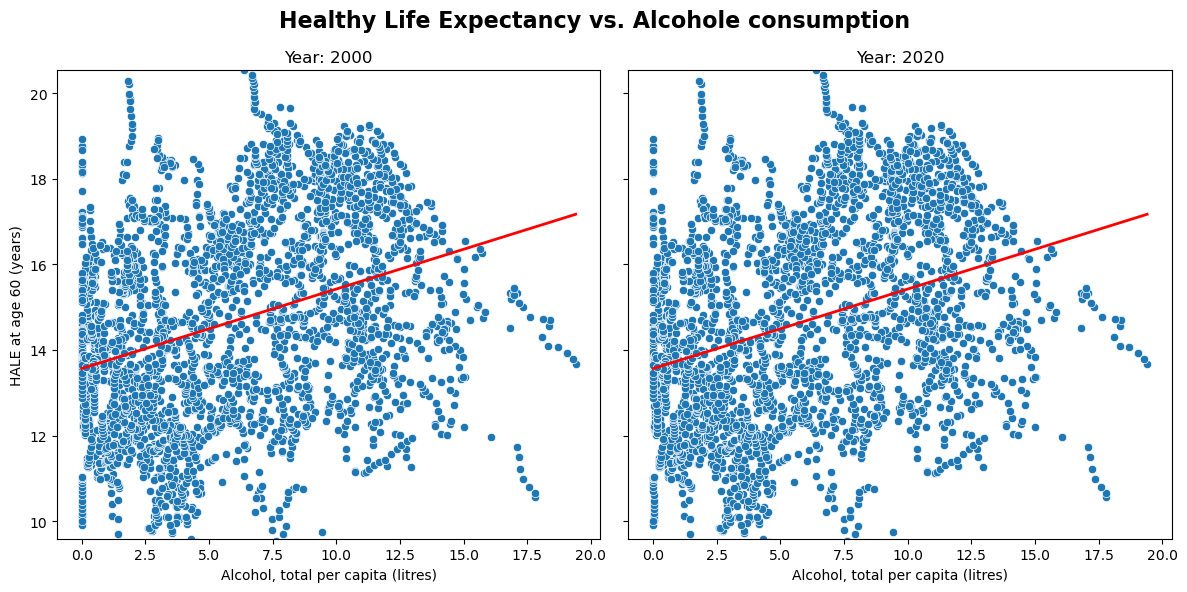

In [55]:
# The graphs Healthy Life Expectancy vs. Alcohole consumption
years = [2000, 2020]
y_min = min(health_data.loc[health_data['Year'].isin(years), 'HALE at age 60 (years)'])
y_max = max(health_data.loc[health_data['Year'].isin(years), 'HALE at age 60 (years)'])

fig, axes = plt.subplots(nrows= 1, ncols=2, figsize=(12, 6), sharey = True)
for i, year in enumerate(years):
    dt = health_data.loc[health_data['Year'] == year]
    ax_ = sns.scatterplot(data = health_data, 
                          x = 'Alcohol, total per capita (litres)', 
                          y = 'HALE at age 60 (years)',
                          ax = axes[i])
    
    # Add trend lines for each income code
    ax_ = sns.regplot(data = health_data, 
                      x = 'Alcohol, total per capita (litres)', 
                      y = 'HALE at age 60 (years)',
                      color = 'red',
                      ci=False, scatter=False, 
                      line_kws={'linewidth': 2, 'linestyle': '-', 'alpha': 1}, 
                      ax = axes[i])
        
    ax_.set_title(f"Year: {year}")
    ax_.set_ylim(y_min, y_max)
    handles, labels = axes[0].get_legend_handles_labels()

# Add the title for the figure
fig.suptitle('Healthy Life Expectancy vs. Alcohole consumption', fontsize = 16, fontweight = 'bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


An examination of the graphs below reveals a possible explanation for the seemingly ‘optimistic’ observation above. When the data is divided by income categories, the correlation between alcohol consumption and Healthy Life Expectancy almost disappears within each category.

My hypothesis is that the observed correlation in the overall dataset is misleading. It likely stems from the fact that poorer countries tend to consume less alcohol and have lower Healthy Life Expectancies due to other factors, such as access to healthcare, nutrition, clean water, sanitation, and more.

Let’s explore this further.

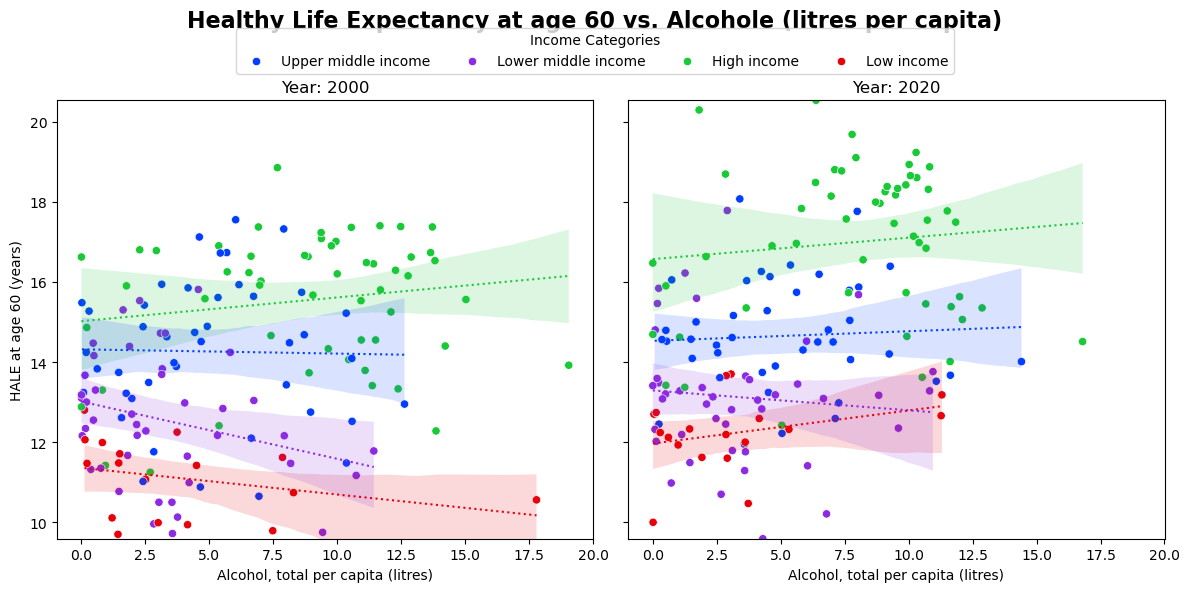

In [100]:
# HALE vs. 'Alcohol, total per capita (litres)'
plot_scatters_income_categories(data = health_data, x = 'Alcohol, total per capita (litres)', y = 'HALE at age 60 (years)',
                                hue = 'WBIncomeCode', legend_title = 'Income Categories', title = 'Healthy Life Expectancy at age 60 vs. Alcohole (litres per capita)',
                                years = [2000, 2020])

The graph below provides evidence: the lower a country’s income, the lower its alcohol consumption in liters of pure alcohol per capita. This explains the strong correlation between Healthy Life Expectancy and alcohol consumption — it is primarily due to their shared correlation with a country’s income level.

It remains possible that alcohol consumption negatively affects Healthy Life Expectancy. However, this effect may be outweighed by other income-related factors, such as access to better healthcare, nutrition, and living conditions, which positively influence Healthy Life Expectancy.

Note: Alcohol consumption tends to converge over time toward the average: it increases in low-income countries, decreases in high-income countries, and remains steady in middle-income countries. 

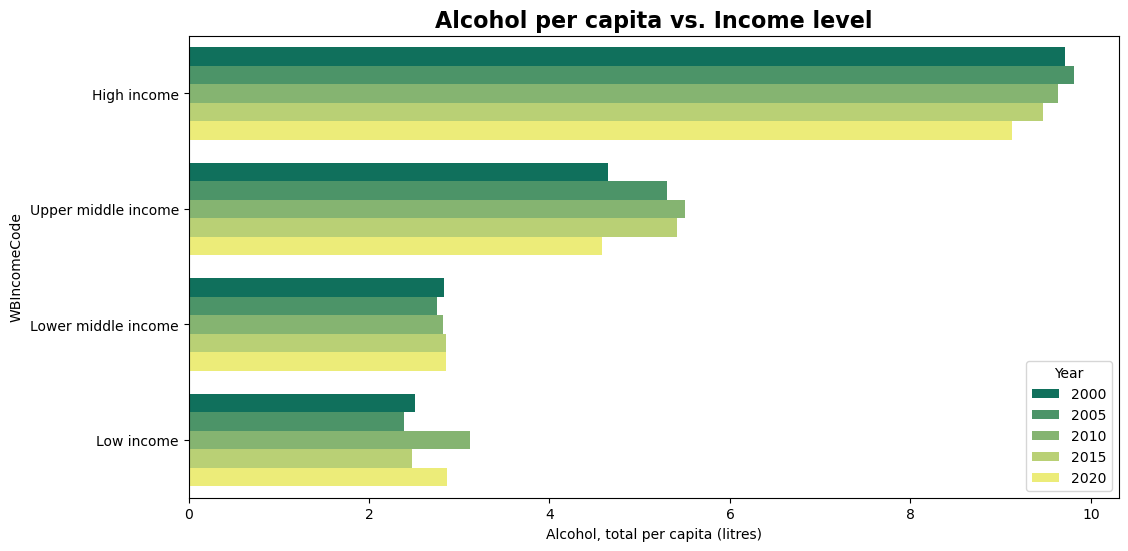

In [93]:
# Alcohol comsumption among income groups
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(data = health_data[health_data['Year'].isin([2000, 2005, 2010, 2015, 2020])], 
            y = 'WBIncomeCode', 
            x = 'Alcohol, total per capita (litres)', 
            hue = 'Year', errorbar = None, 
            estimator = 'median', order = order[::-1], 
            palette= 'summer')

plt.title('Alcohol per capita vs. Income level', fontsize = 16, fontweight = 'bold')
plt.show()

## 6. Smoking Prevalence Shows a Similar Pattern: Higher Smoking Prevalence, Higher HALE

This observation is not surprising, as it mirrors the paradox seen with alcohol consumption.

To avoid repeating the same analysis in detail, I will simply present similar graphs as before and proceed directly to the conclusions.

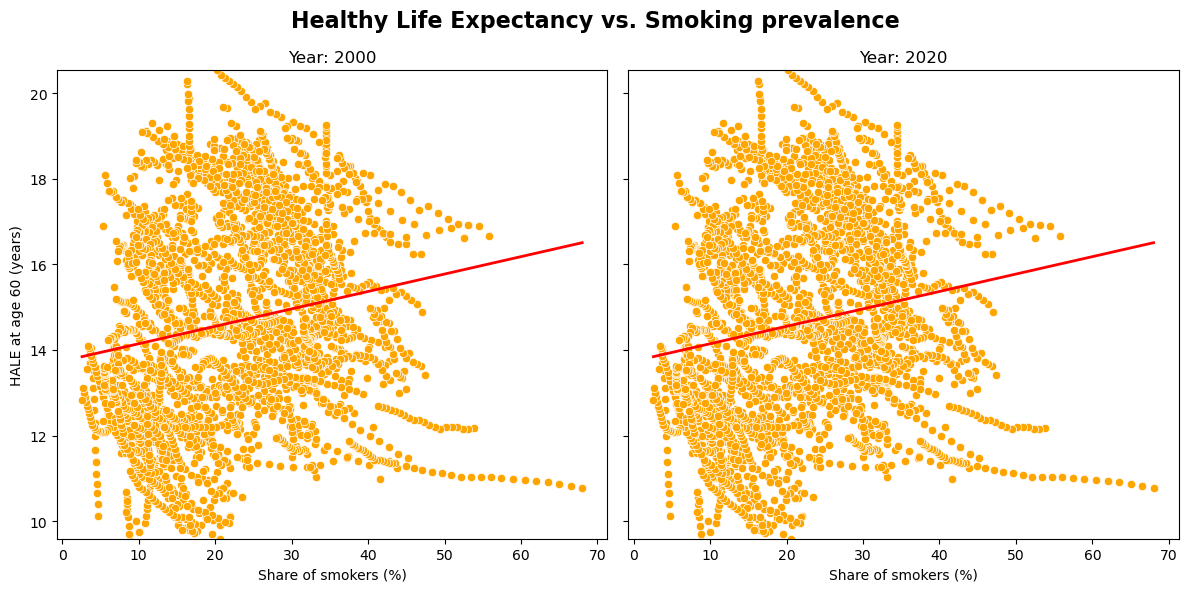

In [61]:
# The graphs Healthy Life Expectancy vs. Smoking prevalence
years = [2000, 2020]
y_min = min(health_data.loc[health_data['Year'].isin(years), 'HALE at age 60 (years)'])
y_max = max(health_data.loc[health_data['Year'].isin(years), 'HALE at age 60 (years)'])

fig, axes = plt.subplots(nrows= 1, ncols=2, figsize=(12, 6), sharey = True)
for i, year in enumerate(years):
    dt = health_data.loc[health_data['Year'] == year]
    ax_ = sns.scatterplot(data = health_data, 
                          x = 'Share of smokers (%)', 
                          y = 'HALE at age 60 (years)',
                          color = 'orange',
                          ax = axes[i])
    
    # Add trend lines for each income code
    ax_ = sns.regplot(data = health_data, 
                      x = 'Share of smokers (%)', 
                      y = 'HALE at age 60 (years)',
                      color = 'red',
                      ci=False, scatter=False, 
                      line_kws={'linewidth': 2, 'linestyle': '-', 'alpha': 1}, 
                      ax = axes[i])
        
    ax_.set_title(f"Year: {year}")
    ax_.set_ylim(y_min, y_max)
    handles, labels = axes[0].get_legend_handles_labels()

# Add the title for the figure
fig.suptitle('Healthy Life Expectancy vs. Smoking prevalence', fontsize = 16, fontweight = 'bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


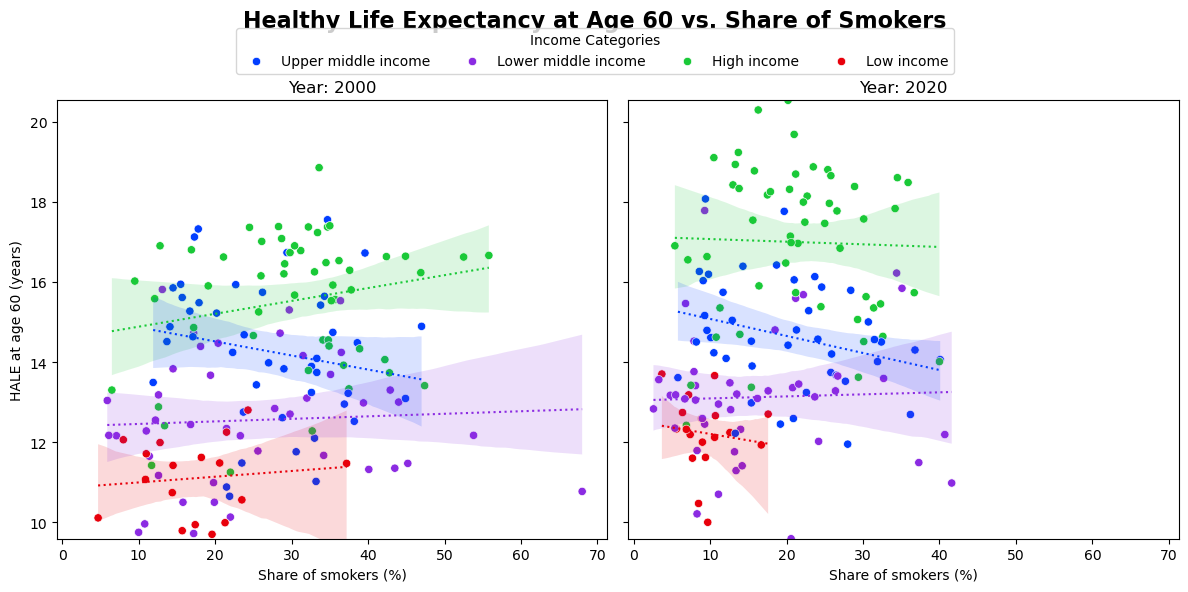

In [101]:
# HALE vs. Smoking prevalence (Share of Smokers)
plot_scatters_income_categories(data = health_data, x = 'Share of smokers (%)', y = 'HALE at age 60 (years)',
                                hue = 'WBIncomeCode', legend_title = 'Income Categories', 
                                title = 'Healthy Life Expectancy at Age 60 vs. Share of Smokers',
                                years = [2000, 2020])

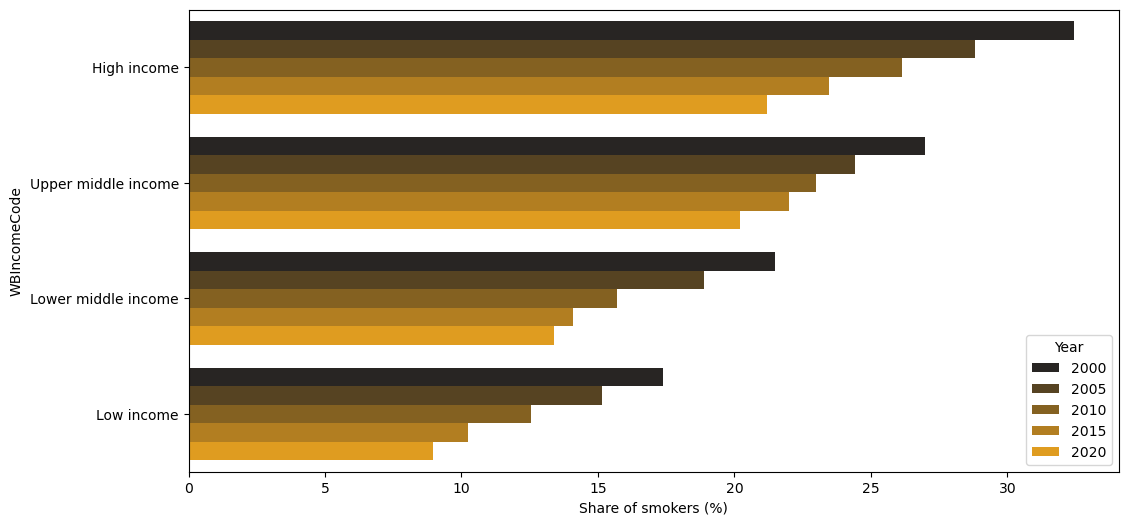

In [84]:
# Smoking prevalence among income groups
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(data = health_data[health_data['Year'].isin([2000, 2005, 2010, 2015, 2020])], 
            y = 'WBIncomeCode', 
            x = 'Share of smokers (%)',
            hue = 'Year', errorbar = None, 
            estimator = 'median', order = order[::-1], 
            palette = 'dark:orange')
plt.show()

Similarly to what was observed earlier with alcohol, there is a positive correlation between HALE and smoking prevalence, primarily driven by their stronger shared correlation with income levels. Both HALE and smoking prevalence increase as a country’s income level rises. This shared correlation with income appears to outweigh the negative correlation between HALE and smoking prevalence.

There is a positive trend of steady decreasing smoking prevalence across all income categories!

## 7. Healthcare Expenses Paradox: Healthcare Spending Doesn’t Clearly Influence Healthy Life Expectancy

In the first graph below, it is challenging to observe any clear correlation between Healthy Life Expectancy and Current Healthcare Expenditures. The relationship is ambiguous, as the confidence interval includes both positive and negative slopes. This suggests that other factors, such as access to polutions, nutrition, clean water, sanitation, and more., may have a greater influence on Healthy Life Expectancy.

However, the second graph reveals that Current Healthcare Expenditures consistently increase across all income categories, indicating the change of societal priority which health is given measured in monetary terms.

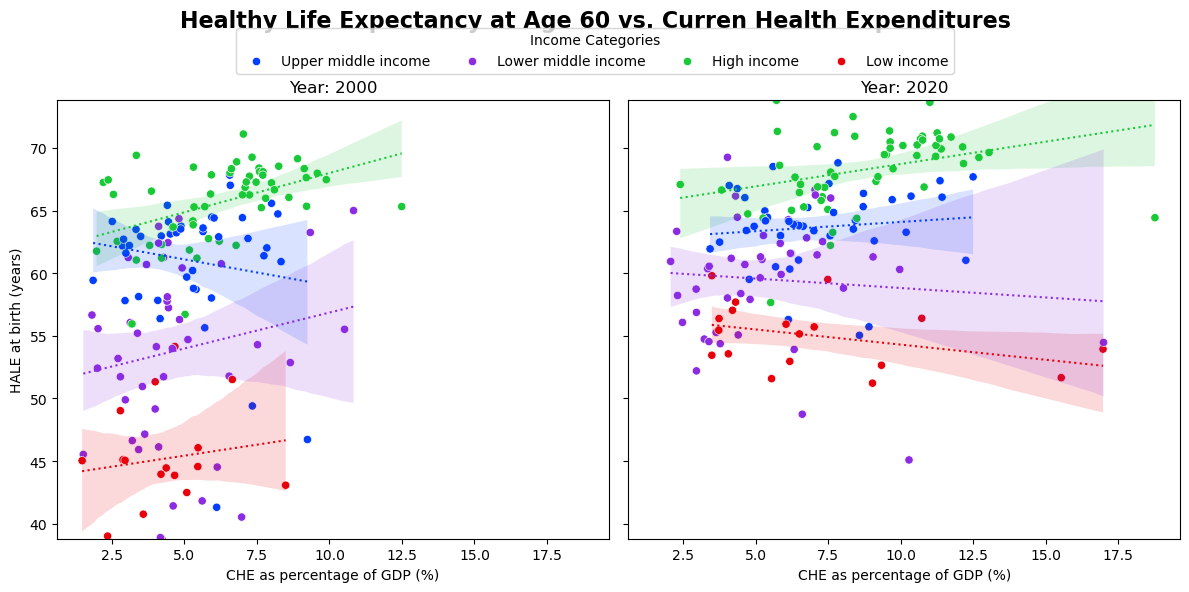

In [103]:
# Healthy Life Expectancy at Age 60 vs. Curren Health Expenditures
plot_scatters_income_categories(data = health_data, x = 'CHE as percentage of GDP (%)', y = 'HALE at birth (years)',
                                hue = 'WBIncomeCode', legend_title = 'Income Categories', 
                                title = 'Healthy Life Expectancy at Age 60 vs. Curren Health Expenditures',
                                years = [2000, 2020])

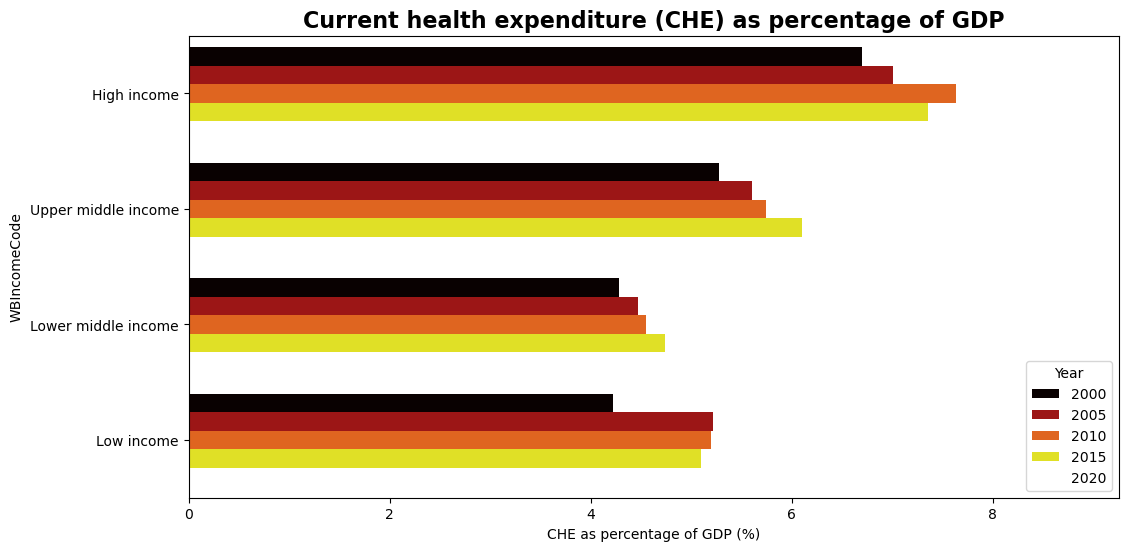

In [106]:
# Smoking prevalence among income groups
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(data = health_data[health_data['Year'].isin([2000, 2005, 2010, 2015, 2020])], 
            y = 'WBIncomeCode', 
            x = 'CHE as percentage of GDP (%)', 
            hue = 'Year', errorbar = None,
            estimator = 'median', order = order[::-1], palette='hot')
plt.title('Current health expenditure (CHE) as percentage of GDP', fontsize = 16, fontweight = 'bold')
plt.show()

__Conclusions:__  

1.	“There are three kinds of lies: lies, damned lies, and statistics.” This phrase, often attributed to Benjamin Disraeli and popularized by Mark Twain, highlights how easily data can be misinterpreted. The paradoxes observed in this analysis demonstrate how misleading conclusions can arise from statistics without a thorough understanding of the underlying data.  

2.	A country’s income level — and the factors it influences — has a far greater impact on health metrics than smoking prevalence, alcohol consumption, or even current healthcare expenditures.  

3.	The most effective approach to analyzing the relationship between health metrics (such as HALE) and behaviors like alcohol consumption or smoking is to compare health outcomes between groups (e.g., smokers vs. non-smokers) while stratifying the analysis by income level.  